In [47]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set3 as invariant_set3
import cp_reach.satellite.plotting as plotting
import sympy as sp

import cp_reach.satellite.mission2 as sat_sim
import cyecca.lie as lie
import casadi as ca

In [48]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
%autoreload 2

# Define Mission Parameters

In [50]:
thrust = 30
ang_vel_dist_deg = 10 # in degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
# gravity_err = 0.02 # m/s^2
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)
acc = [thrust, 0, 0]

In [51]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)

        
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

# 10 Second Burn - Monte Carlo and Reference

In [52]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, 10, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

In [53]:
data_burn[0]['xf']

DM(
[[0, 0.01, 0.02, ..., 9.97, 9.98, 9.99], 
 [0, 30.7015, 61.406, ..., 32098.9, 32132.6, 32166.3], 
 [-4.2164e+07, -4.2164e+07, -4.2164e+07, ..., -4.2164e+07, -4.2164e+07, -4.2164e+07], 
 ...,
 [0, 0, 0, ..., 0, 0, 0], 
 [0, 0, 0, ..., 0, 0, 0], 
 [0, 0, 0, ..., 0, 0, 0]])

In [58]:
xi_points, eta_points, bounds, sol = invariant_set3.solve(np.sqrt(3)*ang_vel_dist_rad, acc, control_gains, num_points=1000)

[array([-0.5+0.8660254j, -0.5-0.8660254j, -0.5+0.8660254j, -0.5-0.8660254j,
       -0.5+0.8660254j, -0.5-0.8660254j, -1. +0.j       , -1. +0.j       ,
       -1. +0.j       ])]


In [37]:
bounds

array([[-0.84381682,  0.29497504],
       [-8.44820968,  8.44820968],
       [-8.44820966,  8.44820966],
       [-0.63355177,  0.27327502],
       [-6.64921423,  6.64921423],
       [-6.64921424,  6.64921424],
       [-0.2771388 ,  0.2771388 ],
       [-0.2771388 ,  0.2771388 ],
       [-0.33907464,  0.33907464]])

Text(0, 0.5, 'deltav z')

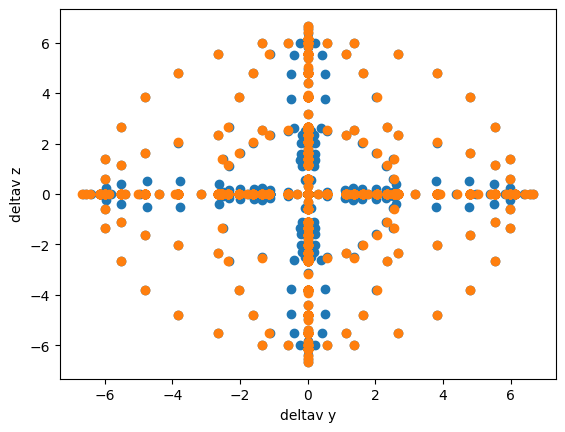

In [38]:
i = 4
j = 5
plt.scatter(eta_points[i,:],eta_points[j,:])
plt.scatter(xi_points[i,:],xi_points[j,:])
plt.xlabel('deltav y')
plt.ylabel('deltav z')

In [ ]:
eta_points.shape

## Compute LMI

In [ ]:
bounds

## Plot

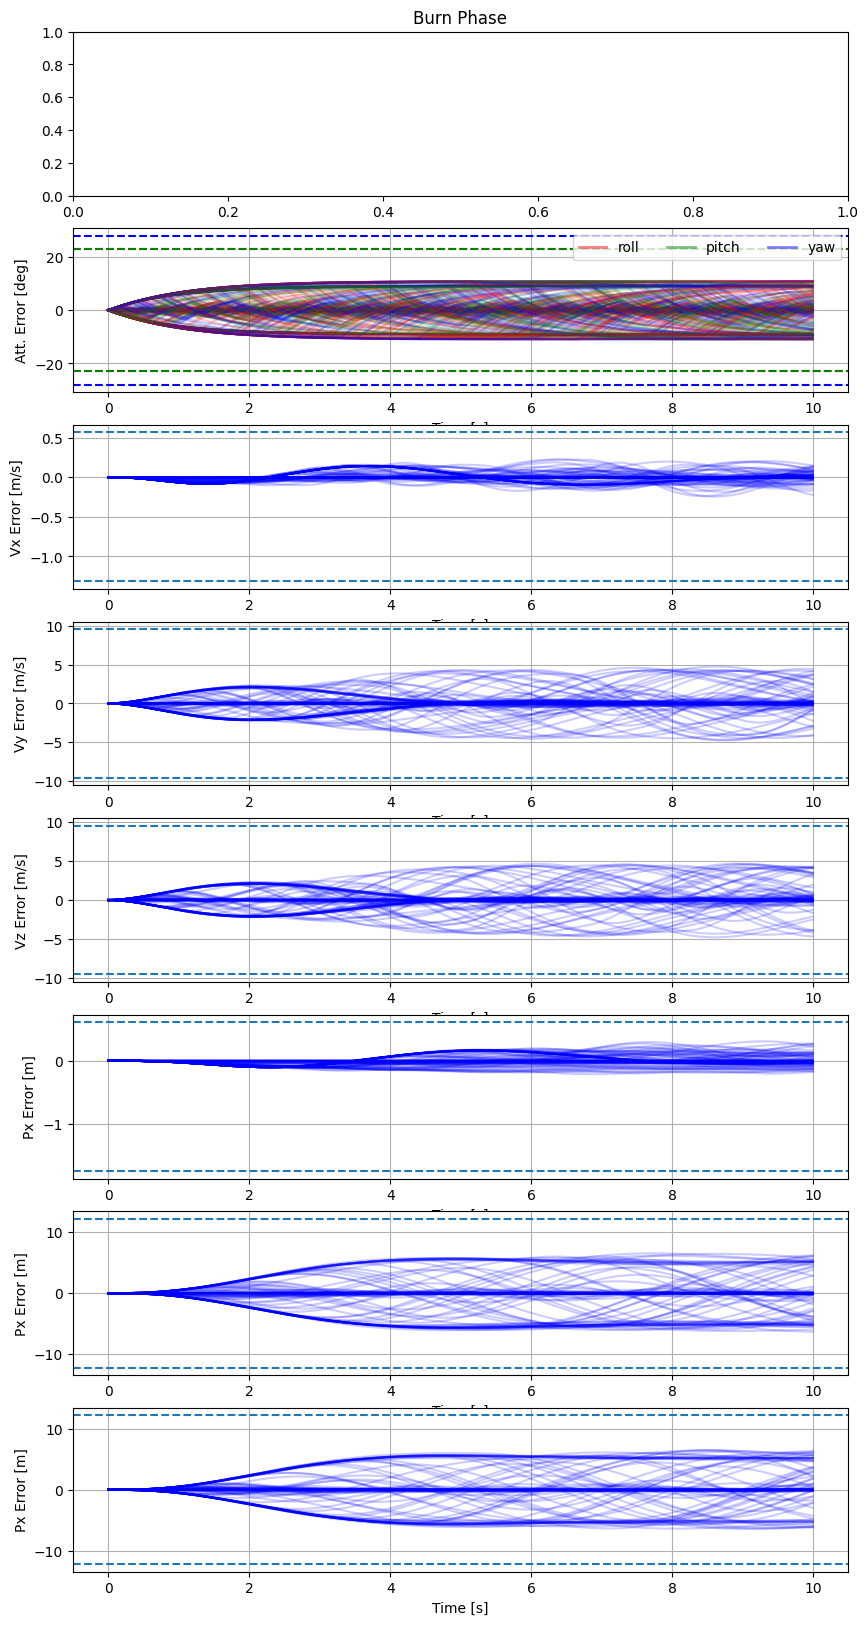

In [59]:
def burn_plotting(data_burn, bounds):
    fig, axes = plt.subplots(8, 1, figsize=(10, 20))
    axes[0].set_title('Burn Phase')
    colors = ['r','g','b']

    # Attitude
    plotting.plot_burn_attitude(axes[1], data_burn)
    for i in range(3):
        axes[1].axhline(y=np.rad2deg(bounds[6+i, 0]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds[6+i, 1]), linestyle='--', color=colors[i])

    # Vx
    plotting.plot_burn_delta_vx_error(axes[2], data_burn)
    axes[2].axhline(y=bounds[3, 0], linestyle='--')
    axes[2].axhline(y=bounds[3, 1], linestyle='--')

    #V y
    plotting.plot_burn_delta_vy_error(axes[3], data_burn)
    axes[3].axhline(y=bounds[4, 0], linestyle='--')
    axes[3].axhline(y=bounds[4, 1], linestyle='--')

    # Vz
    plotting.plot_burn_delta_vz_error(axes[4], data_burn)
    axes[4].axhline(y=bounds[5, 0], linestyle='--')
    axes[4].axhline(y=bounds[5, 1], linestyle='--')

    # Px
    plotting.plot_burn_x_error(axes[5], data_burn)
    axes[5].axhline(y=bounds[0, 0], linestyle='--')
    axes[5].axhline(y=bounds[0, 1], linestyle='--')

    # Py
    plotting.plot_burn_y_error(axes[6], data_burn)
    axes[6].axhline(y=bounds[1, 0], linestyle='--')
    axes[6].axhline(y=bounds[1, 1], linestyle='--')

    # Pz
    plotting.plot_burn_z_error(axes[7], data_burn)
    axes[7].axhline(y=bounds[2, 0], linestyle='--')
    axes[7].axhline(y=bounds[2, 1], linestyle='--')
    
burn_plotting(data_burn, bounds)

In [ ]:
vec = np.array([0, 0, 0, 30, 0, 0, 0, 0, 0])

xi = lie.se23.elem(ca.DM(vec)) # Lie Algebra
ad = lie.se23.adjoint(xi)
ad